In [1]:
!pip install torch torchvision

You are using pip version 9.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

import torch
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms

In [2]:
use_cuda = False
device = torch.device('cuda' if use_cuda else 'cpu')

# Experiment 1: Image Classification

In [67]:
# Default parameters from the PyTorch MNIST example (https://github.com/pytorch/examples/blob/master/mnist/main.py
params = dict(batch_size=64, batch_size_eval=1000, num_epochs=30, learning_rate=0.01, momentum=0.5)

## Load MNIST data and make a noisy variant

In [68]:
image_transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])

raw_train_dataset = datasets.MNIST('data', train=True, download=True, transform=image_transform)
test_dataset = datasets.MNIST('data', train=False, download=True, transform=image_transform)

# Split 5k samples from the train dataset for validation (similar to Sacramento et al. 2018).
# TODO: Maybe seed this? Cannot be done in the method directly, so would need to manually call torch.seed. 
train_dataset, val_dataset = torch.utils.data.dataset.random_split(raw_train_dataset, (55000, 5000))

kwargs = {'num_workers': 3, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=params['batch_size'], shuffle=True, **kwargs)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=params['batch_size_eval'], shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=params['batch_size_eval'], shuffle=False, **kwargs)

In [69]:
from PIL import Image

class AddGaussianNoise(object):
    def __init__(self, mean=0, std=64, scaling_factor=0.5):
        self.mean = mean
        self.std = std
        self.scaling_factor = scaling_factor
    
    def __call__(self, img):
        img_array = np.asarray(img)
        noisy_img_array = img_array + self.scaling_factor * np.random.normal(self.mean, self.std, img_array.shape)
        noisy_img_array = np.clip(noisy_img_array, 0, 255)
        noisy_img_array = noisy_img_array.astype(img_array.dtype)
        return Image.fromarray(noisy_img_array)
        
    def __repr__(self):
        return self.__class__.__name__ + '(mean={}, std={}, scaling_factor={})'.format(self.mean, self.std, self.intensity)

In [83]:
image_transform = transforms.Compose([
                       AddGaussianNoise(scaling_factor=2),
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])

noisy_test_dataset = datasets.MNIST('data', train=False, download=True, transform=image_transform)
noisy_test_loader = torch.utils.data.DataLoader(noisy_test_dataset, batch_size=params['batch_size_eval'], shuffle=False, **kwargs)

In [84]:
#plt.imshow(noisy_test_dataset[4][0])

## Networks

In [72]:
class FeedforwardNet(nn.Module):
    # TODO: Add ability to easily add more hidden layers. 
    def __init__(self, num_hidden=500, dropout=0.5):
        super(FeedforwardNet, self).__init__()
        self.forward1 = nn.Linear(784, num_hidden)
        self.forward2 = nn.Linear(num_hidden, 10)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = x.view(-1, 784)
        x = F.relu(self.forward1(x))
        x = self.dropout(x)
        x = self.forward2(x)
        # TODO: Maybe change to loss function that includes softmax. 
        return F.log_softmax(x, dim=1)

In [73]:
class FeedbackNet(nn.Module):
    def __init__(self, num_hidden=500, dropout=0.5):
        super(FeedbackNet, self).__init__()
        self.forward1 = nn.Linear(784, num_hidden)
        self.forward2 = nn.Linear(num_hidden, 10)
        self.dropout = nn.Dropout(dropout)
        
        self.feedback1 = nn.Linear(num_hidden, 784)
        self.feedback2 = nn.Linear(10, num_hidden)
        
        self.dropout = nn.Dropout(dropout)

    def forward(self, inp):
        inp = inp.view(-1, 784)
        
        x = F.relu(self.forward1(inp))
        feedback_activation_1 = self.feedback1(x)
        
        x = self.dropout(x)
        x = F.log_softmax(self.forward2(x), dim=1)
        feedback_activation_2 = self.feedback2(x)
        # TODO: Maybe change to loss function that includes softmax. 
        
        #print(feedback_activation_1.shape, feedback_activation_2.shape)
        
        # 2nd forward pass, this time with added feedback
        x = F.relu(self.forward1(inp + feedback_activation_1))
        # TODO: Do dropout again here or only on the first pass?
        #x = F.dropout(x, training=self.training)
        x = F.log_softmax(self.forward2(x + feedback_activation_2), dim=1)
        
        return x
        

In [74]:
class ConvNet(nn.Module):
    """ConvNet from the official PyTorch tutorial, achieves around 98 % accuracy on test set (https://github.com/pytorch/examples/blob/master/mnist/main.py)."""
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

## Training

In [79]:
def train(model, device, train_loader, optimizer, epoch, params=None):
    model.train()
    for batch, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        # TODO: Change to loss_function = ..., loss_function(output, target)
        #print(output.shape, target.shape)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch * len(data), len(train_loader.dataset),
                100. * batch / len(train_loader), loss.item()))

In [80]:
def test(model, device, test_loader, params=None):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            # TODO: Change to loss_function = ..., loss_function(output, target)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [81]:
def count_parameters(model):
    return sum(p.numel() for p in filter(lambda p: p.requires_grad, model.parameters()) if p.requires_grad)

In [85]:
import time

#model = FeedforwardNet(num_hidden=500).to(device)
model = FeedbackNet().to(device)
print('Model has', count_parameters(model), 'trainable parameters')

# TODO: Maybe use Adam or Adadelta instead. 
optimizer = optim.SGD(model.parameters(), lr=params['learning_rate'], momentum=params['momentum'])

for epoch in range(params['num_epochs']):
    print('Epoch {}/{}'.format(epoch+1, params['num_epochs']))
    start_time = time.time()
    train(model, device, train_loader, optimizer, epoch+1)
    print('Took', time.time()-start_time, 'seconds')
    test(model, device, test_loader)
    print('Now testing on noisy dataset...')
    test(model, device, noisy_test_loader)

Model has 795794 trainable parameters
Epoch 1/30
Train Epoch: 1 [0/55000 (0%)]	Loss: 2.385131
Train Epoch: 1 [6400/55000 (12%)]	Loss: 0.431386
Train Epoch: 1 [12800/55000 (23%)]	Loss: 0.464762
Train Epoch: 1 [19200/55000 (35%)]	Loss: 0.108397
Train Epoch: 1 [25600/55000 (47%)]	Loss: 0.262161
Train Epoch: 1 [32000/55000 (58%)]	Loss: 0.277559
Train Epoch: 1 [38400/55000 (70%)]	Loss: 0.294778
Train Epoch: 1 [44800/55000 (81%)]	Loss: 0.150399
Train Epoch: 1 [51200/55000 (93%)]	Loss: 0.125782
Took 11.702157258987427 seconds

Test set: Average loss: 0.1754, Accuracy: 9480/10000 (95%)

Now testing on noisy dataset...

Test set: Average loss: 1.2840, Accuracy: 5518/10000 (55%)

Epoch 2/30
Train Epoch: 2 [0/55000 (0%)]	Loss: 0.135305


KeyboardInterrupt: 

# Experiment 2: Sequential Image Classification

In [3]:
params = dict(batch_size=64, batch_size_eval=1000, num_epochs=30, learning_rate=0.01, momentum=0.5)

## Load MNIST dataset and arrange digits in sequences

In [4]:
# TODO: Refactor this to datasets.py.
image_transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])

raw_train_dataset = datasets.MNIST('data', train=True, download=True, transform=image_transform)
test_dataset = datasets.MNIST('data', train=False, download=True, transform=image_transform)

# Split 5k samples from the train dataset for validation (similar to Sacramento et al. 2018).
# TODO: Maybe seed this? Cannot be done in the method directly, so would need to manually call torch.seed. 
train_dataset, val_dataset = torch.utils.data.dataset.random_split(raw_train_dataset, (55000, 5000))

kwargs = {'num_workers': 3, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=params['batch_size'], shuffle=True, **kwargs)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=params['batch_size_eval'], shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=params['batch_size_eval'], shuffle=False, **kwargs)

In [19]:
num_allowed_seqs = 100
seq_len = 5

allowed_seqs = np.random.randint(0, 10, (num_allowed_seqs, seq_len))

In [20]:
import random

class ImageSequenceDataset(torch.utils.data.Dataset):
    def __init__(self, allowed_seqs, image_dataset, num_classes, num_samples=10000):
        self.num_samples = num_samples
        self.allowed_seqs = allowed_seqs
        self.images_per_class = {i: [] for i in range(num_classes)}
        for image, class_ in train_dataset:
            self.images_per_class[class_.item()].append(image)
        
    def __len__(self):
        return self.num_samples
    
    def __getitem__(self, i):
        seq = self.allowed_seqs[i % len(self.allowed_seqs)]
        images = [random.choice(self.images_per_class[class_]) for class_ in seq]
        return torch.cat(images), seq

In [21]:
def plot_image_sequence(images, targets):
    for i in range(len(images)):
        plt.subplot(1, len(images), i+1)
        plt.imshow(images[i], cmap='Greys')
        plt.axis('off')
        plt.title(targets[i])

In [22]:
seq_train_dataset = ImageSequenceDataset(allowed_seqs, train_dataset, 10, num_samples=50000)
seq_test_dataset = ImageSequenceDataset(allowed_seqs, test_dataset, 10, num_samples=10000)

seq_train_loader = torch.utils.data.DataLoader(seq_train_dataset, batch_size=params['batch_size'], shuffle=True, **kwargs)
seq_test_loader = torch.utils.data.DataLoader(seq_test_dataset, batch_size=params['batch_size_eval'], shuffle=False, **kwargs)

In [23]:
len(seq_train_dataset)

50000

In [24]:
seq_train_dataset[0][0].shape

torch.Size([5, 28, 28])

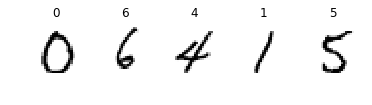

In [25]:
plot_image_sequence(*seq_train_dataset[0])

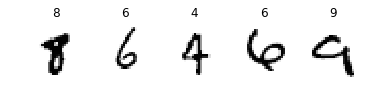

In [26]:
plot_image_sequence(*seq_train_dataset[1])

## Networks

In [14]:
class SequentialLSTM(nn.Module):
    def __init__(self, num_hidden=500):
        super(SequentialLSTM, self).__init__()
        # TODO: Maybe change everything to batch_second.
        self.lstm1 = nn.LSTM(784, num_hidden, batch_first=True)
        self.lstm2 = nn.LSTM(num_hidden, 10, batch_first=True)
        
    def forward(self, inp):
        inp = inp.view(inp.shape[0], inp.shape[1], 784)
        #print(inp.shape)
        x, (hidden, cell) = self.lstm1(inp)
        # TODO: Need to add a non-linearity here?
        x, (hidden, cell) = self.lstm2(x)
        #print(x.shape, hidden.shape, cell.shape)
        #print(x.shape)
        x = F.log_softmax(x, dim=2)
        #print(x.sum(dim=(2)))
        return x

In [35]:
class SequentialFeedforwardNet(nn.Module):
    def __init__(self, num_hidden=500, dropout=0.5):
        super(SequentialFeedforwardNet, self).__init__()
        self.forward1 = nn.Linear(784, num_hidden)
        self.forward2 = nn.Linear(num_hidden, 10)
        self.dropout = nn.Dropout(dropout)

    def forward(self, inp):
        outp = torch.zeros(inp.shape[0], inp.shape[1], 10)
        
        for i, x in enumerate(inp.transpose(0, 1)):
            x = x.view(-1, 784)
            x = F.relu(self.forward1(x))
            x = self.dropout(x)
            x = self.forward2(x)
            # TODO: Maybe change to loss function that includes softmax. 
            x = F.log_softmax(x, dim=1)
            outp[:, i] = x
            
        return outp

In [64]:
class SequentialFeedbackNet(nn.Module):
    def __init__(self, num_hidden=500, dropout=0.5, alpha=0.5):
        super(SequentialFeedbackNet, self).__init__()
        self.forward1 = nn.Linear(784, num_hidden)
        self.forward2 = nn.Linear(num_hidden, 10)
        self.dropout = nn.Dropout(dropout)
        
        self.feedback1 = nn.Linear(num_hidden, 784)
        self.feedback2 = nn.Linear(10, num_hidden)
        self.alpha = alpha
        
        self.dropout = nn.Dropout(dropout)
        self.no_feedback = False
        
    def forward(self, inp):
        outp = torch.zeros(inp.shape[0], inp.shape[1], 10)
        
        feedback_activation_1 = torch.zeros(inp.shape[0], self.forward1.weight.shape[1])
        feedback_activation_2 = torch.zeros(inp.shape[0], self.forward2.weight.shape[1])
        
        for i, x in enumerate(inp.transpose(0, 1)):
            x = x.view(-1, 784)
            x = F.relu(self.forward1((1 - self.alpha) * x + self.alpha * feedback_activation_1))
            # TODO: Is this retained across forward passes?
            feedback_activation_1 = self.feedback1(x)  # for next forward pass
            x = self.dropout(x)
            x = self.forward2((1 - self.alpha) * x +  self.alpha * feedback_activation_2)
            # TODO: Maybe change to loss function that includes softmax. 
            x = F.log_softmax(x, dim=1)
            feedback_activation_2 = self.feedback2(x)  # for next forward pass
            outp[:, i] = x
            
        return outp

    def forward_old(self, inp):
        # inp shape: batch_size, time_steps, 28, 28
        # TODO: Maybe change to batch_second. 
        output = torch.zeros(inp.shape[0], inp.shape[1], 10)  # shape: batch_size, time_steps, 10
        
        for i, x in enumerate(inp.transpose(0, 1)):  # iterate over time dimension
            #print(x.shape)
            
            x = x.view(-1, 784)  # shape: batch_size, 784
            # TODO: Implement multiple feedback passes. 
            
            if i == 0 or self.no_feedback:
                x = self.forward1(x)
            else:
                print(feedback_activation_1.shape)
                #plt.imshow(feedback_activation_1.detach()[0].view(28, 28))
                x = self.forward1(x + self.alpha * feedback_activation_1)
            x = F.relu(x)
            if not self.no_feedback:
                feedback_activation_1 = self.feedback1(x)

            x = self.dropout(x)
            if i == 0 or self.no_feedback:
                x = self.forward2(x)
            else:
                x = self.forward2(x + self.alpha * feedback_activation_2)
            x = F.log_softmax(x, dim=1)
            if not self.no_feedback:
                feedback_activation_2 = self.feedback2(x)

            output[:, i] = x
    
        return output
        

In [54]:
imgs = seq_train_dataset[0][0]
model = SequentialFeedbackNet()
model.forward1.weight.data = ff_model.forward1.weight.data.clone()
model.forward1.bias.data = ff_model.forward1.bias.data.clone()
model.forward2.weight.data = ff_model.forward2.weight.data.clone()
model.forward2.bias.data = ff_model.forward2.bias.data.clone()
model(imgs[None], no_feedback=False)

NameError: name 'ff_model' is not defined

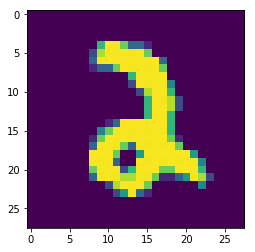

In [172]:
plt.imshow(imgs[0])

## Training

In [63]:
# Good template for hyperparameter optimization:
#def run(train_dataset, val_dataset, device, params, history)
#def 

In [46]:
# TODO: Debug properly.
def train_sequential(model, device, train_loader, optimizer, epoch, params=None):
    model.train()
    for batch, (data, target) in enumerate(seq_train_loader):
        data, target = data.to(device), target.to(device)

        output = model(data)
        #print(output.shape, target.shape)
        
        # TODO: According to https://pytorch.org/tutorials/beginner/nlp/sequence_models_tutorial.html
        #       need to do model.zero_grad() and model.hidden = model.init_hidden() here. 

        loss = F.nll_loss(output.transpose(1, 2), target)  # loss function requires transpose
        loss.backward()
        optimizer.step()
        if batch % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch * len(data), len(train_loader.dataset),
                100. * batch / len(train_loader), loss.item()))

In [47]:
# TODO: Debug properly.
def test_sequential(model, device, test_loader, params=None):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output.transpose(1, 2), target, reduction='sum').item() # sum up batch loss, loss function requires transpose
            
            pred = output.view(-1, output.shape[-1]).max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    # TODO: Make this independent of seq_len (used twice!).
    test_loss /= len(test_loader.dataset) * seq_len
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset) * seq_len,
        100. * correct / (len(test_loader.dataset) * seq_len)))

In [17]:
len([p for p in model.parameters() if p.requires_grad])

NameError: name 'model' is not defined

In [67]:
#model = SequentialFeedforwardNet().to(device)
#model = SequentialLSTM().to(device)
model = SequentialFeedbackNet(dropout=0.5, alpha=0).to(device)
# TODO: Use rmsprop or another optimizer which is good for LSTMs.
#optimizer = optim.SGD([p for p in model.parameters() if p.requires_grad], lr=0.0001, momentum=params['momentum'])
#optimizer = optim.Adam(model.parameters(), lr=0.0001)
optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=params['momentum'])

for epoch in range(params['num_epochs']):
    print('Epoch {}/{}'.format(epoch+1, params['num_epochs']))
    start_time = time.time()
    train_sequential(model, device, seq_train_loader, optimizer, epoch+1)
    print('Took', time.time()-start_time, 'seconds')
    
    test_sequential(model, device, seq_test_loader)
    #print('Now testing on noisy dataset...')
    #test(model, device, noisy_test_loader)

Epoch 1/30
Train Epoch: 1 [0/50000 (0%)]	Loss: 2.348487
Train Epoch: 1 [6400/50000 (13%)]	Loss: 1.029409
Train Epoch: 1 [12800/50000 (26%)]	Loss: 0.685362
Train Epoch: 1 [19200/50000 (38%)]	Loss: 0.685626
Train Epoch: 1 [25600/50000 (51%)]	Loss: 0.854768
Train Epoch: 1 [32000/50000 (64%)]	Loss: 0.842595
Train Epoch: 1 [38400/50000 (77%)]	Loss: 0.857510
Train Epoch: 1 [44800/50000 (90%)]	Loss: 0.559042
Took 17.25441312789917 seconds

Test set: Average loss: 0.2941, Accuracy: 46396/50000 (93%)

Epoch 2/30
Train Epoch: 2 [0/50000 (0%)]	Loss: 0.291564
Train Epoch: 2 [6400/50000 (13%)]	Loss: 0.406237
Train Epoch: 2 [12800/50000 (26%)]	Loss: 0.417039
Train Epoch: 2 [19200/50000 (38%)]	Loss: 0.386074
Train Epoch: 2 [25600/50000 (51%)]	Loss: 0.438656
Train Epoch: 2 [32000/50000 (64%)]	Loss: 0.373355
Train Epoch: 2 [38400/50000 (77%)]	Loss: 0.247864
Train Epoch: 2 [44800/50000 (90%)]	Loss: 0.281522
Took 18.256911039352417 seconds

Test set: Average loss: 0.1679, Accuracy: 47960/50000 (96%)

Epo

Train Epoch: 17 [19200/50000 (38%)]	Loss: 0.229007
Train Epoch: 17 [25600/50000 (51%)]	Loss: 0.681468
Train Epoch: 17 [32000/50000 (64%)]	Loss: 0.806415
Train Epoch: 17 [38400/50000 (77%)]	Loss: 0.418699
Train Epoch: 17 [44800/50000 (90%)]	Loss: 0.278279
Took 17.365716218948364 seconds

Test set: Average loss: 0.1225, Accuracy: 48689/50000 (97%)

Epoch 18/30
Train Epoch: 18 [0/50000 (0%)]	Loss: 0.426534
Train Epoch: 18 [6400/50000 (13%)]	Loss: 0.292203
Train Epoch: 18 [12800/50000 (26%)]	Loss: 0.313897
Train Epoch: 18 [19200/50000 (38%)]	Loss: 0.730151
Train Epoch: 18 [25600/50000 (51%)]	Loss: 0.279924
Train Epoch: 18 [32000/50000 (64%)]	Loss: 0.480329
Train Epoch: 18 [38400/50000 (77%)]	Loss: 0.390277
Train Epoch: 18 [44800/50000 (90%)]	Loss: 0.481792
Took 17.90710711479187 seconds

Test set: Average loss: 0.1345, Accuracy: 48655/50000 (97%)

Epoch 19/30
Train Epoch: 19 [0/50000 (0%)]	Loss: 0.741272
Train Epoch: 19 [6400/50000 (13%)]	Loss: 0.588074
Train Epoch: 19 [12800/50000 (26%)]	

In [60]:
%debug

> <ipython-input-58-981f29c607c0>(23)forward()
     21         for i, x in enumerate(inp.transpose(0, 1)):
     22             x = x.view(-1, 784)
---> 23             x = F.relu(self.forward1((1 - self.alpha) * x + self.alpha * feedback_activation_1))
     24             # TODO: Is this retained across forward passes?
     25             feedback_activation_1 = self.feedback1(x)  # for next forward pass

ipdb> x.shape
torch.Size([64, 784])
ipdb> feedback_activation_1.shape
torch.Size([64, 500])
ipdb> q


In [236]:
model = SequentialFeedbackNet(dropout=0, alpha=0.5).to(device)

In [237]:
model.forward1.weight.data = ff_model.forward1.weight.data.clone()
model.forward1.bias.data = ff_model.forward1.bias.data.clone()
model.forward2.weight.data = ff_model.forward2.weight.data.clone()
model.forward2.bias.data = ff_model.forward2.bias.data.clone()

In [242]:
test_sequential(model, device, seq_test_loader, params)


Test set: Average loss: 0.5467, Accuracy: 46727/10000 (93%)



In [126]:
model.forward1.weight.requires_grad = False
model.forward1.bias.requires_grad = False
model.forward2.weight.requires_grad = False
model.forward2.bias.requires_grad = False


Test set: Average loss: 0.5414, Accuracy: 46792/10000 (94%)



In [86]:
#ff_model = model

In [239]:
test(ff_model, device, test_loader, params)


Test set: Average loss: 0.1806, Accuracy: 9459/10000 (95%)

